## This notebook creates intensity-matrix heatmaps

In [17]:
from pathlib import Path
from definitions import ROOT_DIR
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

In [18]:
def calculate_detected_intensities(df, threshold=0.8):
    '''
    Make a column with background corrected intensities for detected compounds, and 0s for not detected compounds
    Change any negative values to zero
    Also add detectability column, where compounds with prediction value above threshold=0.8 are labelled as detected (1)
    '''

    df['detectability'] = df.pred_val >= threshold
    vals = df.spot_intensity_bgr_corrected * df.detectability
    df['effective_intensity'] = np.clip(vals, 0, None)
    return df


def filter_neutral_losses(df, neutral_losses=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    If neutral_loss value us "only_nl", than consider only ions that have neutral losses
    '''
    
    if neutral_losses == "only_nl":
        df = df[df.neutral_loss != ""]
    elif neutral_losses != None:
        df = df[df.neutral_loss.isin(neutral_losses)]
    return df

def filter_adducts(df, adducts=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if adducts != None:
        df = df[df.adduct.isin(adducts)]
    return df

def filter_polarity(df, polarity=None):
    '''
    Filter out entries based on polarity pol ['positive', 'negative']
    '''
    if polarity != None:
        df = df[df.Polarity == polarity]
    return df

def filter_data(data, polarity=None, adducts=None, neutral_losses=None):
    '''
    Apply polarity, adduct and neutral_loss filters
    '''
    data = filter_polarity(data, polarity)
    data = filter_adducts(data, adducts)
    data = filter_neutral_losses(data, neutral_losses)
     
    return data

def filter_class(df, classification, clas, clas_column):
    '''
    Filter out entries based on coarse class name
    '''
    data = df.merge(classification, on='name_short', how='left')
    filtered_data = data[data[clas_column] == clas].drop(columns=clas_column)
    return filtered_data

def group_by_molecule(df):
    '''
    Aggregate intensity and detection values per metabolite and dataset
    '''
    
    data = df.pivot_table(index=['name_short', 'Matrix short'],
                 values='effective_intensity',
                 aggfunc=lambda x: np.log10(sum(x)+1)).reset_index()
    return data

def zero_fill_data(df, compounds):
    
    # Do zero-filling using a pre-made template
    X = df['Matrix short'].unique()
    Y = compounds['name_short'].unique()
    template = pd.DataFrame(product(X, Y), columns=['Matrix short', 'name_short'])
    data = template.merge(df, on=['Matrix short', 'name_short'], how='left').fillna(0)
    
    return data

def prep_class_data(df, polarity=None, neutral_losses=None, sort_rows_by_class=False, classification=None, class_col_name=None):
    '''
    Prepare data and make one heatmap for all classes
    '''
    # Aggregate intensities per metabolite and pivot into heatmap layout
    molecule_data = group_by_molecule(df)
    
    # Zero-fill data and pivot
    zero_filled_data = zero_fill_data(molecule_data, compounds)
    plot_data = zero_filled_data.pivot(index='name_short',
                                       columns='Matrix short',
                                       values='effective_intensity') 
    
    # Sort columns alphabetically
    column_order = plot_data.columns.sort_values()
    plot_data = plot_data.reindex(column_order, axis=1)
    
    # Sort rows by chemical class
    if sort_rows_by_class:
        plot_data = plot_data.merge(classification, on='name_short', how='left').set_index('name_short')
        plot_data.sort_values(by = [class_col_name, 'name_short'], inplace=True)
        plot_data.drop(columns=class_col_name, inplace=True)
    
    return plot_data

def prep_colour_bar(plot_df, class_df, class_column):
    '''
    Make a colour bar representing classes of compounds in heatmap
    '''    
    name_to_class =  dict(zip( class_df.name_short,
                               class_df[class_column] ))
    unique_categories = plot_df.index.map(name_to_class).unique()
#     unique_categories = class_df[class_column].unique() # this is basically all classes in cassification file
    
    class_to_color = dict(zip( unique_categories, 
                               sns.hls_palette( len(unique_categories), h=.5 )))
    
    row_colors = plot_df.index.map(name_to_class).map(class_to_color)
    
    return class_to_color, row_colors

- Inputs

In [19]:
p_root_dir = Path(ROOT_DIR).parents[0]
p_data = p_root_dir / "5_data_analysis"
p_out = p_root_dir / "6_plots/q2_plots/heatmaps"

# Metrics and Catboost predictions for all ions in their target wells
p_predictions = p_data / "all_predictions_curated_11-Dec-2021.csv"

# Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / "Datasets_14Jul2022.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"
p_pathways = p_data / "pathways_v2.csv"

# Compounds name and ID information
p_compounds = p_data / "compounds_ids.csv"

- Load files

In [20]:
# Load predictions, format neutral loss column
predictions = pd.read_csv(p_predictions, index_col=0)[['dataset_id', 
                                                       'name_short', 
                                                       'adduct', 
                                                       'neutral_loss', 
                                                       'pred_val',
                                                       'spot_intensity_bgr_corrected']]
predictions.neutral_loss.fillna('', inplace=True)

# Add dataset metadata 
datasets = pd.read_csv(p_datasets)
datasets_info = datasets.groupby('Dataset ID').first()[['Polarity', 'Matrix short', 'Matrix long', 'Slide code', 'EMBL']]
datasets_info['sample_name'] = datasets_info['Matrix short']

# Merge with predictions
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Dataset ID', how='left')

# Filter to keep only datasets chosen for plots about matrix comparison
df = df[df.EMBL]

# Only consider data of detected ions
df = calculate_detected_intensities(df, threshold=0.8)
data = df[df.detectability]

In [21]:
# Load compound metadata
compounds = pd.read_csv(p_compounds, index_col='internal_id')
compounds = compounds[compounds.hmdb_primary != 'custom'][['name_short']] # to exclude thermometer ions

# Load classification
chem_classification_file = pd.read_csv(p_chem_class, index_col='internal_id')
chem_class = chem_classification_file[['name_short', 'main_coarse_class']].drop_duplicates()
chem_subclass = chem_classification_file

### Part 1: One heatmap with all chemical classes

In [22]:
def plot_all_class_heatmap(plot_data, cmap, row_colors, lut, row_cluster, col_cluster, title):
    '''Plot one heatmap for with classes'''
    g = sns.clustermap(plot_data, metric="euclidean", 
                       yticklabels=False, 
                       row_colors=row_colors,
                       row_cluster=row_cluster,
                       col_cluster=col_cluster,
                       cmap=cmap,
                       vmax=5.5) # set max value of the colour bar

    # Beautify the plot
    ax = g.ax_heatmap # define axes
    ax.set(xlabel=None, ylabel=None) # hide axes labels
    g.ax_row_dendrogram.set_visible(False) # hiderow dendrogram

        # Set title and give it space above the plot
    g.fig.subplots_adjust(top=0.9, right=0.95)
    g.fig.suptitle(title)
    
        # Adjust colour bar size and location            
    g.ax_cbar.set_position((0.96, 0.075, 0.03, 0.65)) #x, y, w, l

        # Construct legend
    handles = [Patch(facecolor=lut[name]) for name in lut]
    plt.legend(handles, lut, title='Chemical class',
               bbox_to_anchor=(0.17, 0.5), bbox_transform=plt.gcf().transFigure, loc='upper right')        
    return g

- Make a test plot

In [23]:
# Choose colourmap
cmap = sns.choose_colorbrewer_palette('s') #, as_cmap=True)

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

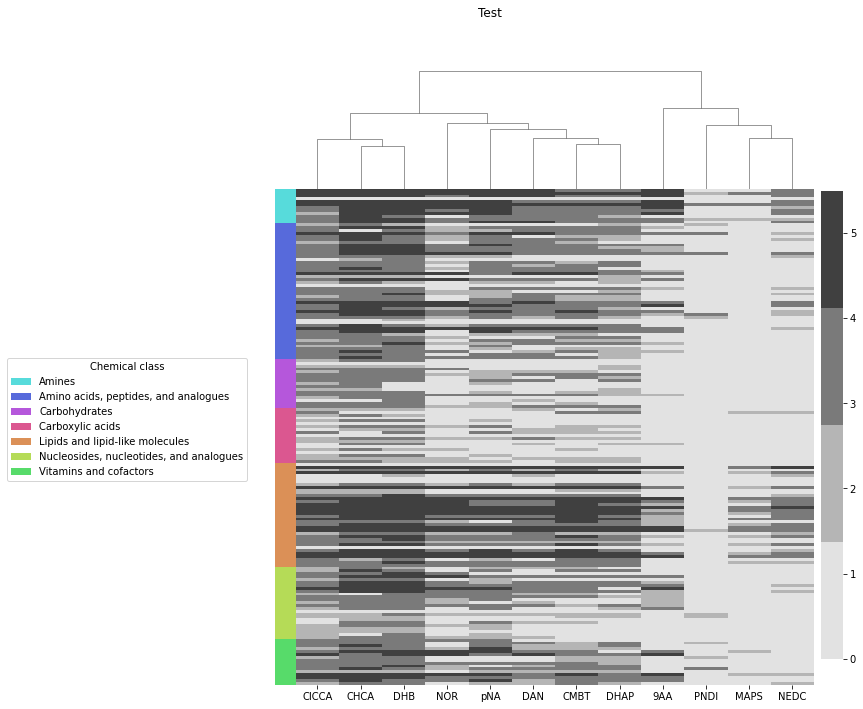

In [24]:
# Filter data
filtered_data = filter_data(data,
                            polarity='positive', 
                            neutral_losses=[''])

# Prepare data to plot
plot_data = prep_class_data(filtered_data,
                     sort_rows_by_class=True,
                     classification=chem_class,
                     class_col_name='main_coarse_class')

# Prepare a colour bar
lut, row_colors = prep_colour_bar(plot_data,
                                  chem_class, 
                                  'main_coarse_class')


# Make the plot
g = plot_all_class_heatmap(plot_data,
                           cmap,
                           row_colors, 
                           lut, 
                           row_cluster=False, 
                           col_cluster=True,
                           title = f"Test")

# Save the plot
# g.savefig(p_out / f"log10 intensities.png") 

- Batch-save many plots with changing filters:

1. With and without neutral losses
2. In both ionisation modes

In [25]:
for neutral_losses in [['']]: #[None, [''], 'only_nl']:
    
    nl_label = 'with n.l.'
    if neutral_losses == ['']: 
        nl_label = 'no n.l.'  
    elif neutral_losses == 'only_nl':
        nl_label = 'only n.l.'  

    for polarity in ['positive', 'negative', None]:
        
        # Filter data
        filtered_data = filter_data(data,
                                    polarity=polarity, 
                                    neutral_losses=neutral_losses)

        # Prepare data to plot
        plot_data = prep_class_data(filtered_data,
                             sort_rows_by_class=True,
                             classification=chem_class,
                             class_col_name='main_coarse_class')

        # Save data for seriation in R
        plot_data.to_csv(p_out / f"data_for_seriation_{polarity}_{nl_label}.csv")

        # Prepare a colour bar
        lut, row_colors = prep_colour_bar(plot_data,
                                          chem_class, 
                                          'main_coarse_class')
        
        # Make the plot
        title = f"log10 intensities {nl_label} {polarity}"
        g = plot_all_class_heatmap(plot_data, 
                                   cmap,
                                   row_colors, 
                                   lut, 
                                   row_cluster=False, 
                                   col_cluster=False, # Change this to enable column clustering
                                   title=title)

        # Save the plot
        g.savefig(p_out / f"{title}.png")
        plt.close()

### Part 2: Seriation in R

- Could be done on csvs saved in part 1
- Describe how you do it if you do it

### Part 3: Class-specific plots

In [26]:
def plot_one_class_heatmap(plot_data, cmap, row_colors, lut, row_cluster, col_cluster, title):
    '''Plot one heatmap for with classes'''
    g = sns.clustermap(plot_data, 
                       metric="euclidean", 
                       yticklabels=True, 
                       row_colors=row_colors,
                       row_cluster=row_cluster,
                       col_cluster=col_cluster,
                       cmap=cmap,
                       vmax=5.5) # set max value of the colour bar

    # Beautify the plot
    ax = g.ax_heatmap # define axes
    ax.set(xlabel=None, ylabel=None) # hide axes labels
    g.ax_row_dendrogram.set_visible(False) # hiderow dendrogram

        # Set title and give it space above the plot
    g.fig.subplots_adjust(top=0.9, right=0.95)
    g.fig.suptitle(title)
    
        # Adjust colour bar size and location            
    g.ax_cbar.set_position((0.14, 0.075, 0.03, 0.65)) #x, y, w, l

        # Construct legend
    handles = [Patch(facecolor=lut[name]) for name in lut]
    plt.legend(handles, lut, title='Chemical class',
               bbox_to_anchor=(0.1, 0.5), bbox_transform=plt.gcf().transFigure, loc='upper right')        
    return g

- Make a test plot

In [27]:
# Choose colourmap
cmap = sns.choose_colorbrewer_palette('s')#, as_cmap=True)

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

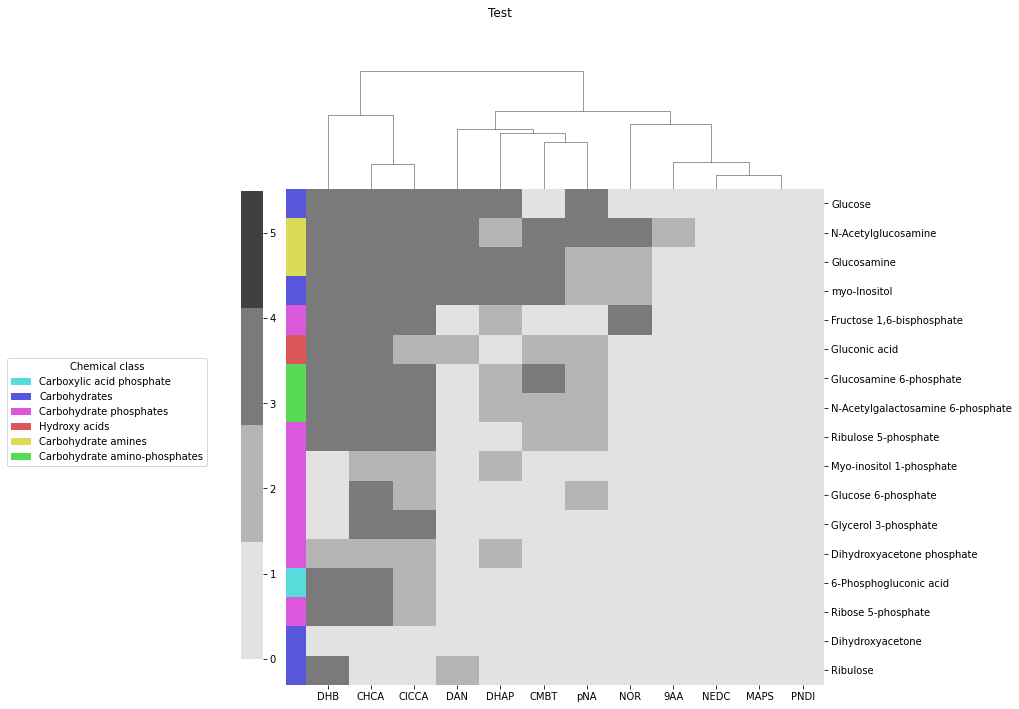

In [28]:
# Filter data
filtered_data = filter_data(data,
                            polarity='positive', 
                            neutral_losses=[''])

# Prepare data to plot
molecule_data = prep_class_data(filtered_data)

# Filter by class
plot_data = filter_class(molecule_data,
                         classification=chem_subclass[['name_short', 'coarse_class']],
                         clas='Carbohydrates',
                         clas_column='coarse_class').set_index('name_short')

# Prepare a colour bar
lut, row_colors = prep_colour_bar(plot_data,
                                  chem_subclass, 
                                  'fine_class')


# Make the plot
g = plot_one_class_heatmap(plot_data,
                           cmap,
                           row_colors, 
                           lut, 
                           row_cluster=True, 
                           col_cluster=True,
                           title = f"Test")

- Batch-save separate plots for every coarse class with changing filters:

1. With and without neutral losses
2. In both ionisation modes

In [29]:
for neutral_losses in [['']]: #[None, [''], 'only_nl']:

    nl_label = 'with n.l.'
    if neutral_losses == ['']: 
        nl_label = 'no n.l.'  
    elif neutral_losses == 'only_nl':
        nl_label = 'only n.l.'  

    for polarity in ['positive', 'negative']:

        # Filter polarity and neutral losses
        filtered_data = filter_data(data,
                                    polarity=polarity, 
                                    neutral_losses=neutral_losses)
        # Aggregate by metabolite
        molecule_data = prep_class_data(filtered_data)
        
        for clas in chem_class.main_coarse_class.unique():
    
            # Filter by class
            plot_data = filter_class(molecule_data,
                                     classification=chem_subclass[['name_short', 'coarse_class']],
                                     clas=clas,
                                     clas_column='coarse_class').set_index('name_short')

            # Prepare a colour bar
            lut, row_colors = prep_colour_bar(plot_data,
                                              chem_subclass, 
                                              'fine_class')

            # Make the plot
            title = f"log10 intensities {clas} {nl_label} {polarity}"
            g = plot_one_class_heatmap(plot_data,
                                       cmap,
                                       row_colors, 
                                       lut, 
                                       row_cluster=True, 
                                       col_cluster=True,
                                       title=title)

            # Save the plot
            g.savefig(p_out / f"{title}.png")
            plt.close()  